In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext, ROUND_HALF_UP
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from pylab import*
from scipy.signal import find_peaks
from collections import Counter

In [8]:

def get_pass_angle(pos_a1_now, pos_a2_now, pos_a3_now, pos_d_now, pos_b_now, pos_b_next):

    rel_pos_a1_to_a2 = pos_a2_now - pos_a1_now
    rel_pos_a1_to_a3 = pos_a3_now - pos_a1_now
    rel_pos_a1_to_d  = pos_d_now  - pos_a1_now

    def get_angle(v1, v2):
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        cos_theta = np.dot(v1, v2) / (norm1 * norm2)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        return np.arccos(cos_theta) * 180 / np.pi

    theta_a2_d = get_angle(rel_pos_a1_to_a2, rel_pos_a1_to_d)
    theta_a3_d = get_angle(rel_pos_a1_to_a3, rel_pos_a1_to_d)

    ball_vec = pos_b_next - pos_b_now

    def get_similarity(v1, v2):
        v1_u = v1 / np.linalg.norm(v1)
        v2_u = v2 / np.linalg.norm(v2)
        return np.dot(v1_u, v2_u)

    sim_to_a2 = get_similarity(ball_vec, rel_pos_a1_to_a2)
    sim_to_a3 = get_similarity(ball_vec, rel_pos_a1_to_a3)

    if sim_to_a2 > sim_to_a3:
        pass_target = "a2"
    else:
        pass_target = "a3"

    return theta_a2_d, theta_a3_d, pass_target


def initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode, threshold=1e-2):
    dist_now_1 = np.linalg.norm(attacker1_pos_episode[0] - ball_pos_episode[0])
    dist_now_2 = np.linalg.norm(attacker2_pos_episode[0] - ball_pos_episode[0])
    dist_now_3 = np.linalg.norm(attacker3_pos_episode[0] - ball_pos_episode[0])
    
    if dist_now_1 > threshold and dist_now_2 > threshold and dist_now_3 > threshold:
        if dist_now_1 < dist_now_2 and dist_now_1 < dist_now_3:
            pass_outcome_a1 = 1
            pass_outcome_a2 = 0
            pass_outcome_a3 = 0
        elif dist_now_2 < dist_now_1 and dist_now_2 < dist_now_3:
            pass_outcome_a1 = 0
            pass_outcome_a2 = 1
            pass_outcome_a3 = 0
        elif dist_now_3 < dist_now_1 and dist_now_3 < dist_now_1:
            pass_outcome_a1 = 0
            pass_outcome_a2 = 0
            pass_outcome_a3 = 1
    
    else:
        pass_outcome_a1 = 0
        pass_outcome_a2 = 0
        pass_outcome_a3 = 0

    return pass_outcome_a1, pass_outcome_a2, pass_outcome_a3


def last_pass_check(defender_pos_episode, ball_pos_episode, threshold=1e-2):
    dist_now = np.linalg.norm(defender_pos_episode[-1] - ball_pos_episode[-1])
    
    if dist_now < threshold:
        last_pass = 0
    else:
        last_pass = 1

    return last_pass


def get_last_pass_index(pass_outcome):
    try:
        return len(pass_outcome) - 1 - pass_outcome[::-1].index(1)
    except ValueError:
        return -1  

    
def get_similarity(v1, v2):
        v1_u = v1 / np.linalg.norm(v1)
        v2_u = v2 / np.linalg.norm(v2)
        return np.dot(v1_u, v2_u)

# Fig. 3b,c

E


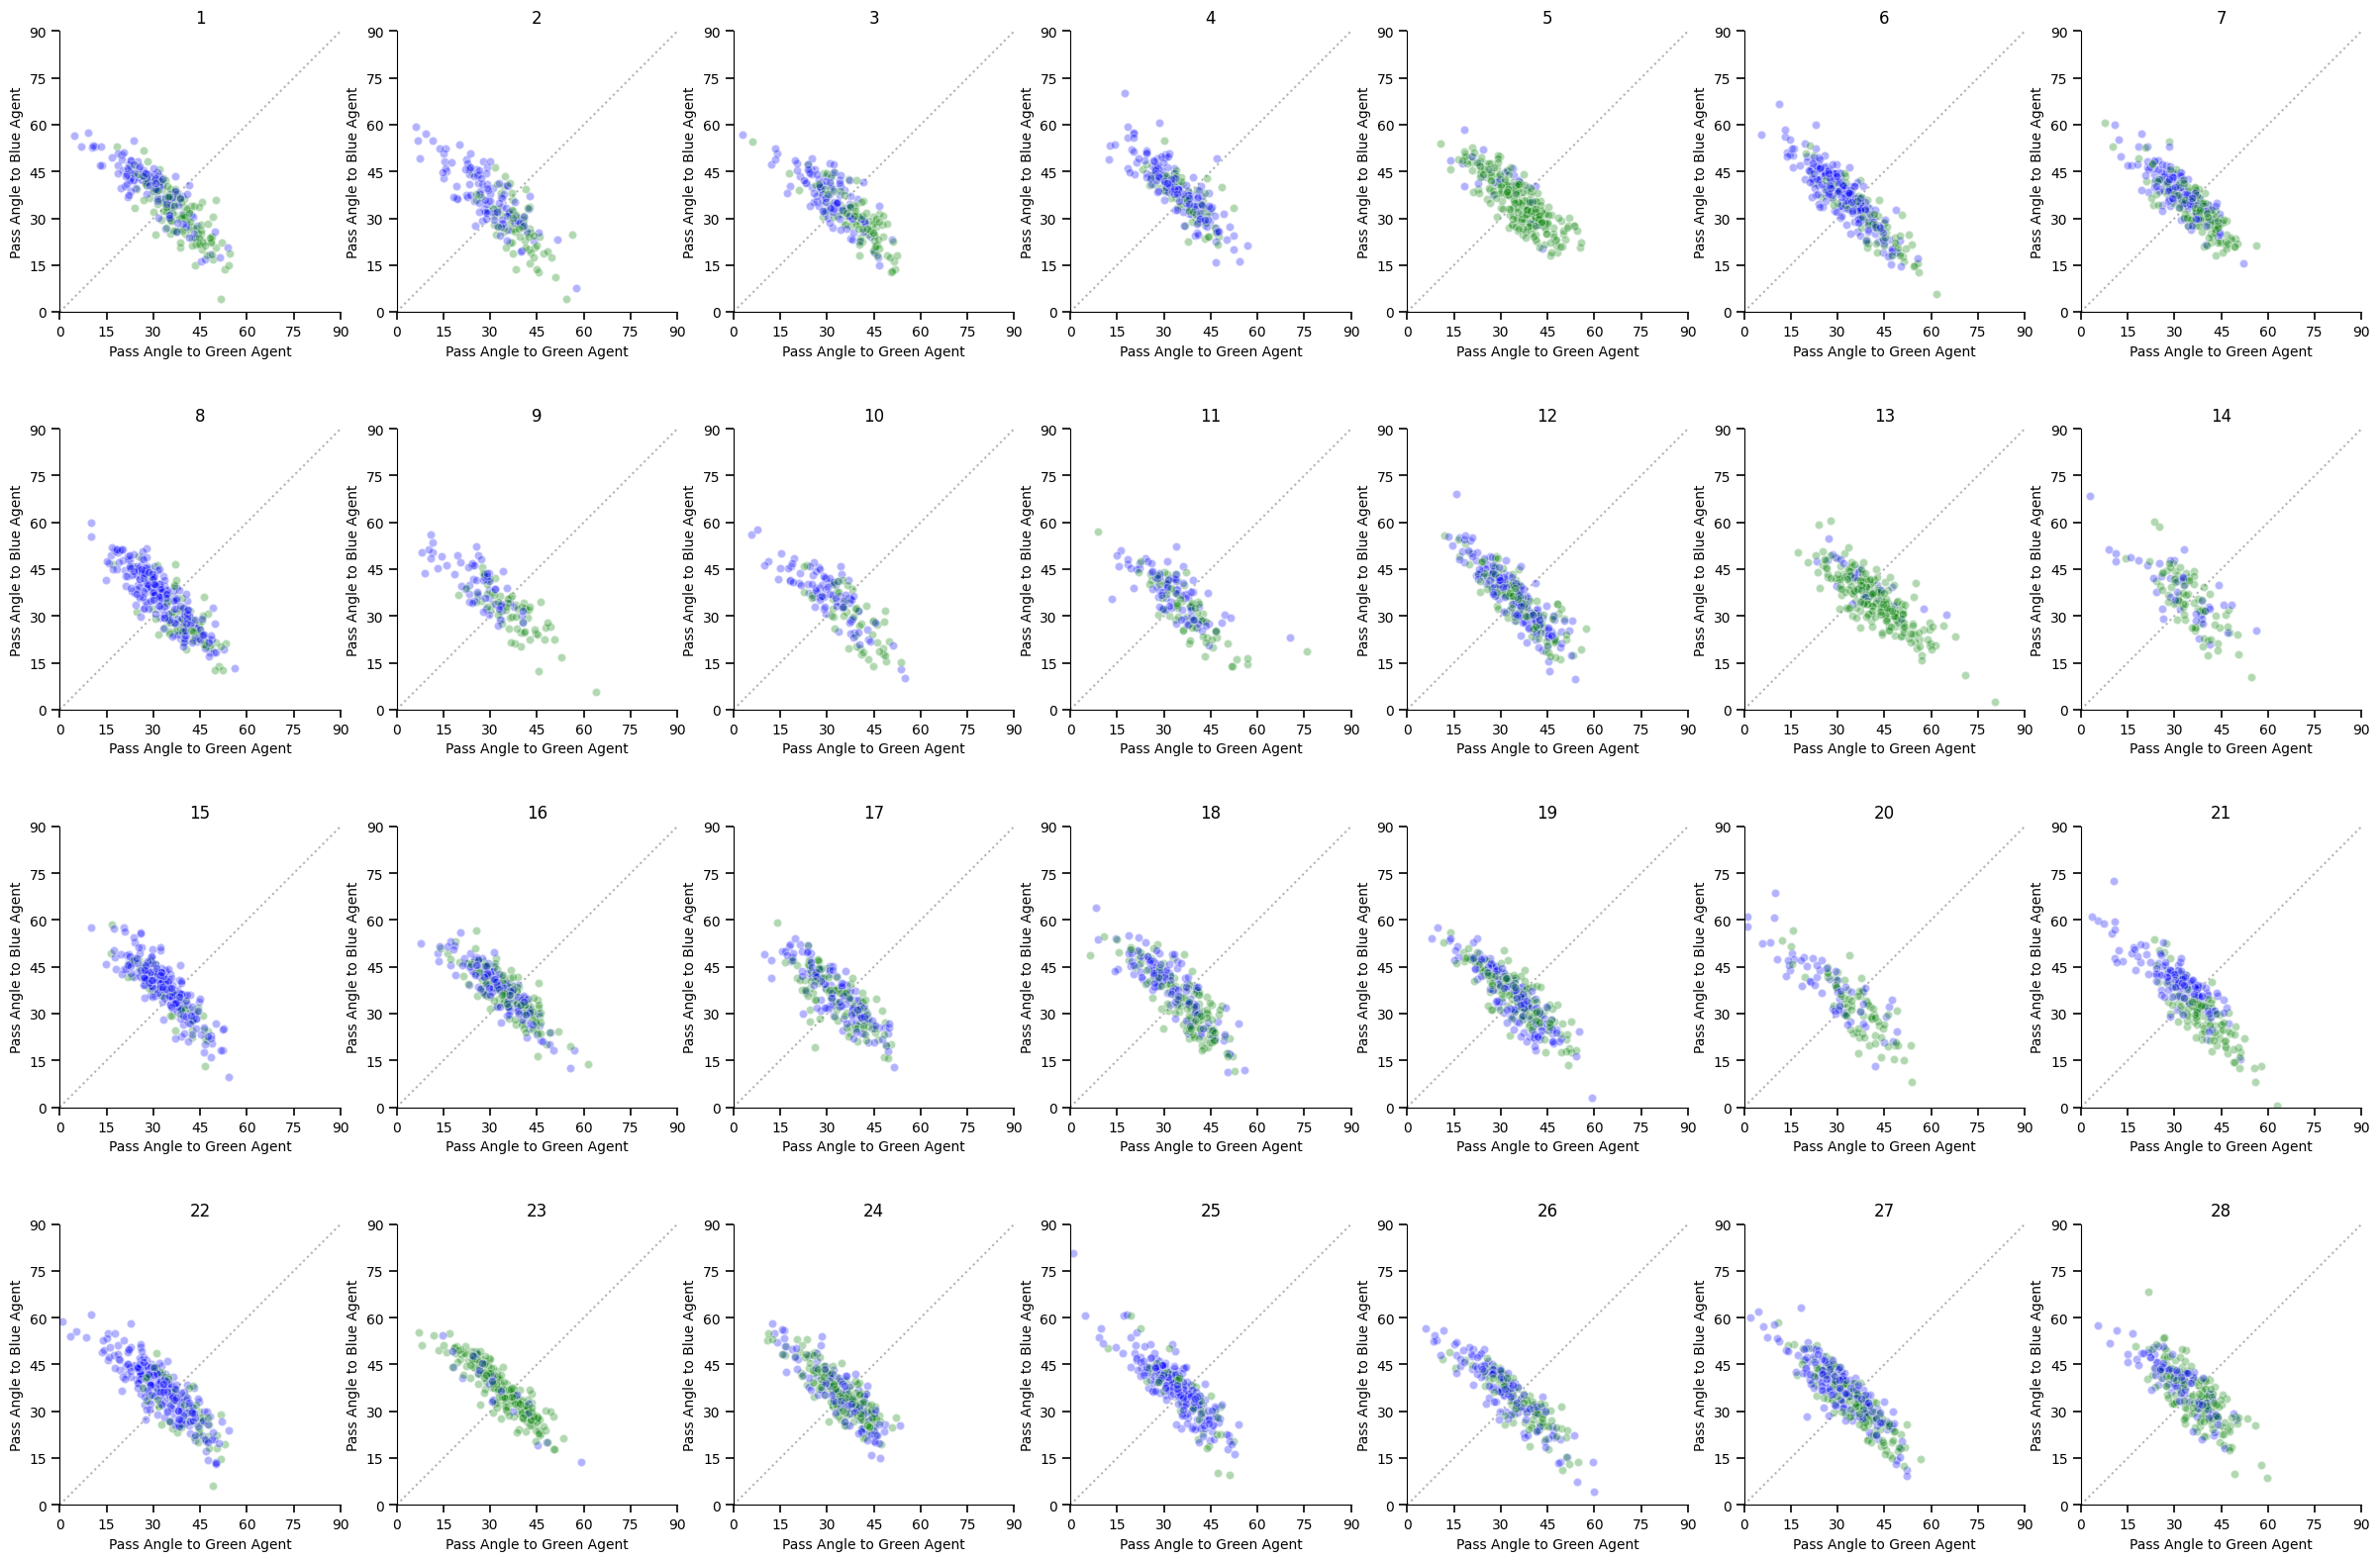

In [6]:
# alphabets = list("ABCDEFGHI") 
alphabets = list("E") 

for alphabet_num in range(len(alphabets)):
    print(alphabets[alphabet_num])
    
    fig = plt.figure(figsize=(30,20))
    
    for sub_num in range(28):
        
        sub = '{0:03d}'.format(sub_num+1)

        ax = fig.add_subplot(4, 7, sub_num +1)
        ax.plot([0, 90], [0, 90], linestyle='dotted', color='gray', alpha=0.6, zorder=0)

        pass_angle_a1 = []
        pass_angle_a2 = []
        pass_angle_a3 = []
        pass_to_a1 = []
        pass_to_a2 = []
        pass_to_a3 = []

        for con_num in range(3):

            con_alphabet = alphabets[alphabet_num]       
            condition = con_alphabet + str(con_num + 1)  

            load_name = "../data/sub/sub" + sub +"/sub" + sub +"_" + condition + ".npy"
            pos_list = np.load(load_name, allow_pickle=True)
            
            for episode in range(8):
                
                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode = pos_episode[4]
                
                threshold = 1e-2
                for t in range(len(defender_pos_episode) - 1):                
                    
                    # attacker1
                    dist_now_1 = np.linalg.norm(attacker1_pos_episode[t] - ball_pos_episode[t])
                    dist_next_1 = np.linalg.norm(attacker1_pos_episode[t+1] - ball_pos_episode[t+1])
                    
                    if dist_now_1 < threshold and dist_next_1 >= threshold:
                        pass_ang_a2, pass_ang_a3, pass_to = get_pass_angle(attacker1_pos_episode[t], attacker2_pos_episode[t], attacker3_pos_episode[t], defender_pos_episode[t], ball_pos_episode[t], ball_pos_episode[t+1])
                        
                        pass_angle_a1.append([pass_ang_a2, pass_ang_a3])
                        pass_to_a1.append(pass_to)
                    else:
                        pass                    

        for i in range(len(pass_angle_a1)):

            pass_angle_i = pass_angle_a1[i]
            pass_to_i = pass_to_a1[i]

            if pass_to_i == "a2":
                ax.scatter(pass_angle_i[0], pass_angle_i[1], color='green', edgecolor='white', alpha=0.3)
            elif pass_to_i == "a3":
                ax.scatter(pass_angle_i[0], pass_angle_i[1], color='blue', edgecolor='white', alpha=0.3)

        ax.set_xlabel("Pass Angle to Green Agent")
        ax.set_ylabel("Pass Angle to Blue Agent")
        ax.set_xlim(0, 90)
        ax.set_ylim(0, 90)
        ax.set_xticks([0, 15, 30, 45, 60,  75, 90])
        ax.set_yticks([0, 15, 30, 45, 60,  75, 90])
        ax.set_aspect('equal', adjustable='box')
        box = ax.get_position()
        ax.tick_params(
            axis='both', direction='out', length=6, width=1.2,
            bottom=True, top=False, left=True, right=False
        )
        [ax.spines[side].set_visible(False) for side in ['right', 'top']]
        ax.set_title(f"{sub_num+1}")                
        
    plt.show()


# Fig. 3d-f

A
B
C
D
E
F
G
H
I


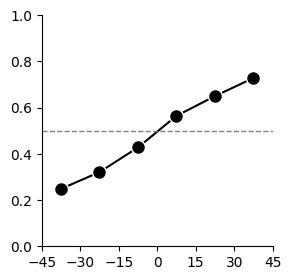

In [24]:
alphabets = list("ABCDEFGHI")

edges   = np.arange(-45, 45 + 15, 15)
centers = (edges[:-1] + edges[1:]) / 2.0
num_bins = len(edges) - 1

all_p_mat = []
for alphabet_num in range(len(alphabets)):
    alphabet = alphabets[alphabet_num]
    print(alphabet)

    p_mat = np.full((28, num_bins), np.nan, dtype=float)

    for sub_idx in range(28):
        sub = f"{sub_idx+1:03d}"

        sub_delta = []
        sub_pass2 = []
        for con_num in range(3):
            con_alphabet = alphabets[alphabet_num]
            condition = con_alphabet + str(con_num + 1)
            load_name = f"../data/sub/sub{sub}/sub{sub}_{condition}.npy"

            pos_list = np.load(load_name, allow_pickle=True)

            for episode in range(8):
                catch_a1 = False

                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode     = pos_episode[4]

                threshold = 1e-2
                T = len(defender_pos_episode)

                for t in range(T - 1):
                    pos_d_now  = defender_pos_episode[t]
                    pos_a1_now = attacker1_pos_episode[t]
                    pos_a1_next= attacker1_pos_episode[t+1]
                    pos_a2_now = attacker2_pos_episode[t]
                    pos_a3_now = attacker3_pos_episode[t]
                    pos_b_now  = ball_pos_episode[t]
                    pos_b_next = ball_pos_episode[t+1]

                    if not catch_a1:
                        if (np.linalg.norm(pos_a1_now - pos_b_now) > threshold and
                            np.linalg.norm(pos_a1_next - pos_b_next) <= threshold):
                            catch_a1 = True

                    if catch_a1:
                        if (np.linalg.norm(pos_a1_now  - pos_b_now)  < threshold and
                            np.linalg.norm(pos_a1_next - pos_b_next) >= threshold):

                            rel_pos_a1_to_a2 = pos_a2_now - pos_a1_now
                            rel_pos_a1_to_a3 = pos_a3_now - pos_a1_now
                            ball_vec = pos_b_next - pos_b_now

                            sim_to_a2 = get_similarity(ball_vec, rel_pos_a1_to_a2)
                            sim_to_a3 = get_similarity(ball_vec, rel_pos_a1_to_a3)

                            theta_a2_d, theta_a3_d, _ = get_pass_angle(pos_a1_now, pos_a2_now, pos_a3_now, pos_d_now, pos_b_now, pos_b_next)
                            delta = theta_a2_d - theta_a3_d

                            if sim_to_a2 > sim_to_a3:
                                pass_a2 = 1
                            else:
                                pass_a2 = 0

                            sub_delta.append(delta)
                            sub_pass2.append(pass_a2)

                            catch_a1 = False

        if len(sub_delta) > 0:
            sub_delta = np.array(sub_delta)
            sub_pass2 = np.array(sub_pass2)

            for i in range(num_bins):
                if i < num_bins - 1:
                    mask = (sub_delta >= edges[i]) & (sub_delta < edges[i+1])
                else:
                    mask = (sub_delta >= edges[i]) & (sub_delta <= edges[i+1])
                n_i = int(mask.sum())
                if n_i > 0:
                    p_mat[sub_idx, i] = sub_pass2[mask].mean()

    mean_prop = np.nanmean(p_mat, axis=0)
    all_p_mat.append(mean_prop)

all_mean_prop = np.mean(all_p_mat, axis=0)

point_size = 100
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.set_box_aspect(1)
ax.axhline(0.5, ls='--', c='gray', lw=1)
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-45, 45)
ax.set_xticks(np.arange(-45, 45+15, 15))
ax.plot(centers, all_mean_prop, color='black', zorder=0, alpha=1)
ax.scatter(centers, all_mean_prop, color='black', edgecolor='white', s=point_size, zorder=1, alpha=1)
for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
        
plt.show()


A
B
C
D
E
F
G
H
I


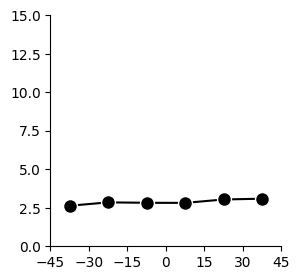

In [39]:
edges   = np.arange(-45, 45 + 15, 15)
centers = (edges[:-1] + edges[1:]) / 2.0
num_bins = len(edges) - 1

all_rt_mat = []
for alphabet in alphabets:
    print(alphabet)

    rt_mat = np.full((28, num_bins), np.nan, dtype=float)

    for sub_idx in range(28):
        sub = f"{sub_idx+1:03d}"

        sub_delta = []
        sub_rt    = []
        for con_num in range(3):
            condition = alphabet + str(con_num + 1)
            load_name = f"../data/sub/sub{sub}/sub{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)

            for episode in range(8):
                catch_a1 = False
                response_time = 0

                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode     = pos_episode[4]

                threshold = 1e-2
                T = len(attacker1_pos_episode)

                for t in range(T - 1):
                    pos_d_now   = defender_pos_episode[t]
                    pos_a1_now  = attacker1_pos_episode[t]
                    pos_a1_next = attacker1_pos_episode[t+1]
                    pos_a2_now  = attacker2_pos_episode[t]
                    pos_a3_now  = attacker3_pos_episode[t]
                    pos_b_now   = ball_pos_episode[t]
                    pos_b_next  = ball_pos_episode[t+1]

                    if not catch_a1:
                        if (np.linalg.norm(pos_a1_now - pos_b_now) > threshold and
                            np.linalg.norm(pos_a1_next - pos_b_next) <= threshold):
                            catch_a1 = True
                            response_time = 0

                    if catch_a1:
                        if (np.linalg.norm(pos_a1_now  - pos_b_now)  < threshold and
                            np.linalg.norm(pos_a1_next - pos_b_next) >= threshold):

                            theta_a2_d, theta_a3_d, _ = get_pass_angle(
                                pos_a1_now, pos_a2_now, pos_a3_now, pos_d_now, pos_b_now, pos_b_next
                            )
                            delta = float(theta_a2_d - theta_a3_d)

                            sub_delta.append(delta)
                            sub_rt.append(response_time)

                            catch_a1 = False
                        else:
                            response_time += 1

        if len(sub_delta) > 0:
            sub_delta = np.asarray(sub_delta, dtype=float)
            sub_rt    = np.asarray(sub_rt,    dtype=float)

            for i in range(num_bins):
                if i < num_bins - 1:
                    mask = (sub_delta >= edges[i]) & (sub_delta < edges[i+1])
                else:
                    mask = (sub_delta >= edges[i]) & (sub_delta <= edges[i+1])

                if np.any(mask):
                    rt_mat[sub_idx, i] = np.mean(sub_rt[mask])

    mean_rt  = np.nanmean(rt_mat, axis=0)
    all_rt_mat.append(mean_rt)

all_rt_mat = np.asarray(all_rt_mat)
all_mean_rt = np.nanmean(all_rt_mat, axis=0)

point_size = 100
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.set_box_aspect(1)
ax.axhline(0, ls='-', c='white')  # 体裁用
ax.set_xlim(-45, 45)
ax.set_ylim(0, 15)
ax.set_xticks([-45, -30, -15, 0, 15, 30, 45])
ax.set_yticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
ax.plot(centers, all_mean_rt, color='black', zorder=0, alpha=1)
ax.scatter(centers, all_mean_rt, color='black', edgecolor='white', s=point_size, zorder=1, alpha=1)

for side in ['right', 'top']:
    ax.spines[side].set_visible(False)

plt.show()


A
B
C
D
E
F
G
H
I
Coverage within [-45, 45] bins: 98.15%  (45720 / 46584 passes)


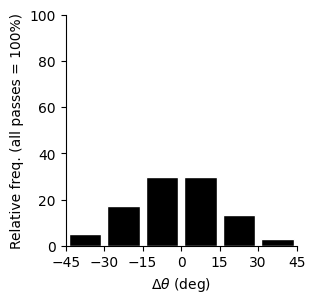

In [38]:
edges   = np.arange(-45, 45 + 15, 15)
num_bins = len(edges) - 1

all_counts = []
all_denoms = []

for alphabet in alphabets:
    print(alphabet)

    n_mat = np.zeros((28, num_bins), dtype=int)
    cond_total_passes = 0

    for sub_idx in range(28):
        sub = f"{sub_idx+1:03d}"
        sub_delta = []; sub_pass2 = []

        for con_num in range(3):
            f = f"../data/sub/sub{sub}/sub{sub}_{alphabet}{con_num+1}.npy"
            pos_list = np.load(f, allow_pickle=True)

            for ep in range(8):
                catch_a1 = False
                pos = pos_list[ep]
                d, a1, a2, a3, b = pos[0], pos[1], pos[2], pos[3], pos[4]
                T = len(d); thr = 1e-2

                for t in range(T-1):
                    a1_now, a1_next = a1[t], a1[t+1]
                    a2_now, a3_now  = a2[t], a3[t]
                    b_now,  b_next  = b[t],  b[t+1]
                    d_now           = d[t]

                    if not catch_a1 and (np.linalg.norm(a1_now-b_now) > thr and
                                         np.linalg.norm(a1_next-b_next) <= thr):
                        catch_a1 = True

                    if catch_a1 and (np.linalg.norm(a1_now-b_now) < thr and
                                     np.linalg.norm(a1_next-b_next) >= thr):
                        ball_vec = b_next - b_now
                        num = np.linalg.norm(ball_vec)
                        if num < 1e-12:
                            catch_a1 = False
                            continue
                            
                        th2, th3, _ = get_pass_angle(a1_now, a2_now, a3_now, d_now, b_now, b_next)
                        delta = float(th2 - th3)
                            
                        cond_total_passes += 1

                        for i in range(num_bins):
                            if i < num_bins - 1:
                                in_bin = (delta >= edges[i]) & (delta < edges[i+1])
                            else:
                                in_bin = (delta >= edges[i]) & (delta <= edges[i+1])
                            if in_bin:
                                n_mat[sub_idx, i] += 1
                                break

                        catch_a1 = False

    counts_per_bin = n_mat.sum(axis=0).astype(float)
    all_counts.append(counts_per_bin)
    all_denoms.append(cond_total_passes)

total_counts = np.sum(np.vstack(all_counts), axis=0).astype(float)  # [-45,45]内
total_den    = float(np.sum(all_denoms))                             # 全Δ角度の全パス
total_rel    = (total_counts / total_den * 100.0) if total_den > 0 else np.zeros_like(total_counts)
coverage = (np.sum(total_counts) / total_den * 100.0) if total_den > 0 else 0.0
print(f"Coverage within [-45, 45] bins: {coverage:.2f}%  "
      f"({int(np.sum(total_counts))} / {int(total_den)} passes)")
    
gap_ratio = 0.85
w = np.diff(edges) * gap_ratio
x = edges[:-1] + (np.diff(edges) - w) / 2.0

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1); ax.set_box_aspect(1)
ax.bar(x, total_rel, width=w, color="black", align="edge", alpha=1, edgecolor="white")
ax.set_xlim(-45, 45)
ax.set_xticks([-45, -30, -15, 0, 15, 30, 45])
ax.set_ylim(0, 100)
ax.set_yticks([0,20,40,60,80,100])
ax.set_xlabel(r"$\Delta\theta$ (deg)")
ax.set_ylabel("Relative freq. (all passes = 100%)")
for side in ['right','top']: ax.spines[side].set_visible(False)

plt.show()


A


/var/folders/1k/r77w29d51kqfkwst93rc05k00000gn/T/ipykernel_26290/2601460790.py:20: RuntimeWarning: invalid value encountered in divide
  v1_u = v1 / np.linalg.norm(v1)


B
C
D


/var/folders/1k/r77w29d51kqfkwst93rc05k00000gn/T/ipykernel_26290/2601460790.py:20: RuntimeWarning: divide by zero encountered in divide
  v1_u = v1 / np.linalg.norm(v1)


E
F
G
H
I


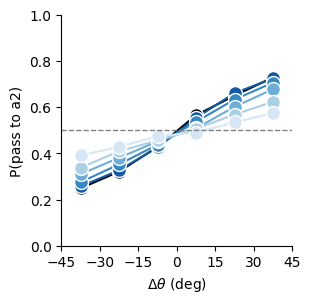

In [37]:
skip_count = 0
total_count = 0

def Blues_colors(n):
    return sns.color_palette("Blues_r", n)

edges   = np.arange(-45, 45 + 15, 15)
centers = (edges[:-1] + edges[1:]) / 2.0
num_bins = len(edges) - 1

OFFSETS = [0, 1, 2, 3, 4, 5]
labels  = [r"$t$", r"$t-1$", r"$t-2$", r"$t-3$", r"$t-4$", r"$t-5$"]
    
Blues = Blues_colors(len(OFFSETS)-1)  # 5色
offset_colors = {0: (0, 0, 0)}
for k, c in zip(OFFSETS[1:], Blues):
    offset_colors[k] = c

all_p_mat = []
for alphabet in alphabets:
    print(alphabet)

    p_mat = np.full((len(OFFSETS), 28, num_bins), np.nan, dtype=float)

    for sub_idx in range(28):
        sub = f"{sub_idx+1:03d}"

        sub_delta_list = [[] for _ in OFFSETS]
        sub_pass2_list = [[] for _ in OFFSETS]

        for con_num in range(3):
            condition = alphabet + str(con_num + 1)
            load_name = f"../data/sub/sub{sub}/sub{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)

            for episode in range(8):
                catch_a1 = False

                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode = pos_episode[4]

                threshold = 1e-2
                T = len(defender_pos_episode)

                for t in range(T - 1):
                    pos_d_now  = defender_pos_episode[t]
                    pos_a1_now = attacker1_pos_episode[t]
                    pos_a1_next= attacker1_pos_episode[t+1]
                    pos_a2_now = attacker2_pos_episode[t]
                    pos_a3_now = attacker3_pos_episode[t]
                    pos_b_now  = ball_pos_episode[t]
                    pos_b_next = ball_pos_episode[t+1]

                    if not catch_a1:
                        if (np.linalg.norm(pos_a1_now - pos_b_now) > threshold and
                            np.linalg.norm(pos_a1_next - pos_b_next) <= threshold):
                            catch_a1 = True

                    if catch_a1 and (
                        np.linalg.norm(pos_a1_now  - pos_b_now)  < threshold and
                        np.linalg.norm(pos_a1_next - pos_b_next) >= threshold
                    ):
                        ball_vec = pos_b_next - pos_b_now
                        sim_to_a2 = get_similarity(ball_vec, (pos_a2_now - pos_a1_now))
                        sim_to_a3 = get_similarity(ball_vec, (pos_a3_now - pos_a1_now))
                        if sim_to_a2 == sim_to_a3:
                            pass_a2 = None
                        else:
                            pass_a2 = 1 if sim_to_a2 > sim_to_a3 else 0

                        if pass_a2 is not None:
                            # t, t-1, ..., t-5
                            for oi, k in enumerate(OFFSETS):
                                tau = t - k
                                if tau < 0:
                                    continue
                                pos_d_tau   = defender_pos_episode[tau]
                                pos_a1_tau  = attacker1_pos_episode[tau]
                                pos_a2_tau  = attacker2_pos_episode[tau]
                                pos_a3_tau  = attacker3_pos_episode[tau]
                                pos_b_tau   = ball_pos_episode[tau]
                                pos_b_taup1 = ball_pos_episode[tau+1]

                                theta_a2_d, theta_a3_d, _ = get_pass_angle(
                                    pos_a1_tau, pos_a2_tau, pos_a3_tau, pos_d_tau,
                                    pos_b_tau, pos_b_taup1
                                )
                                delta_tau = theta_a2_d - theta_a3_d
                                sub_delta_list[oi].append(delta_tau)
                                sub_pass2_list[oi].append(pass_a2)

                        catch_a1 = False

        for oi in range(len(OFFSETS)):
            if len(sub_delta_list[oi]) == 0:
                continue
            sub_delta = np.asarray(sub_delta_list[oi], dtype=float)
            sub_pass2 = np.asarray(sub_pass2_list[oi], dtype=int)

            for i in range(num_bins):
                if i < num_bins - 1:
                    mask = (sub_delta >= edges[i]) & (sub_delta < edges[i+1])
                else:
                    mask = (sub_delta >= edges[i]) & (sub_delta <= edges[i+1])
                n_i = int(mask.sum())
                if n_i > 0:
                    p_mat[oi, sub_idx, i] = sub_pass2[mask].mean()

    mean_props = np.nanmean(p_mat, axis=1)
    all_p_mat.append(mean_props)

stack = np.stack(all_p_mat, axis=0)
mean_over_cond = np.nanmean(stack, axis=0)

point_size = 100
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.set_box_aspect(1)

for oi, lab in enumerate(labels):
    m = mean_over_cond[oi]
    
    ax.plot(centers, m, color=offset_colors[oi],  zorder=0, alpha=1)
    ax.scatter(centers, m, color=offset_colors[oi], edgecolor='white', s=point_size, zorder=1, alpha=1, label=lab)

for side in ['right','top']: ax.spines[side].set_visible(False)

ax.axhline(0.5, ls='--', c='gray', lw=1)
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-45, 45)
ax.set_xticks([-45, -30, -15, 0, 15, 30, 45])
ax.set_xlabel(r"$\Delta\theta$ (deg)")
ax.set_ylabel("P(pass to a2)")

plt.show()


# Fig. 3h-j

0
E


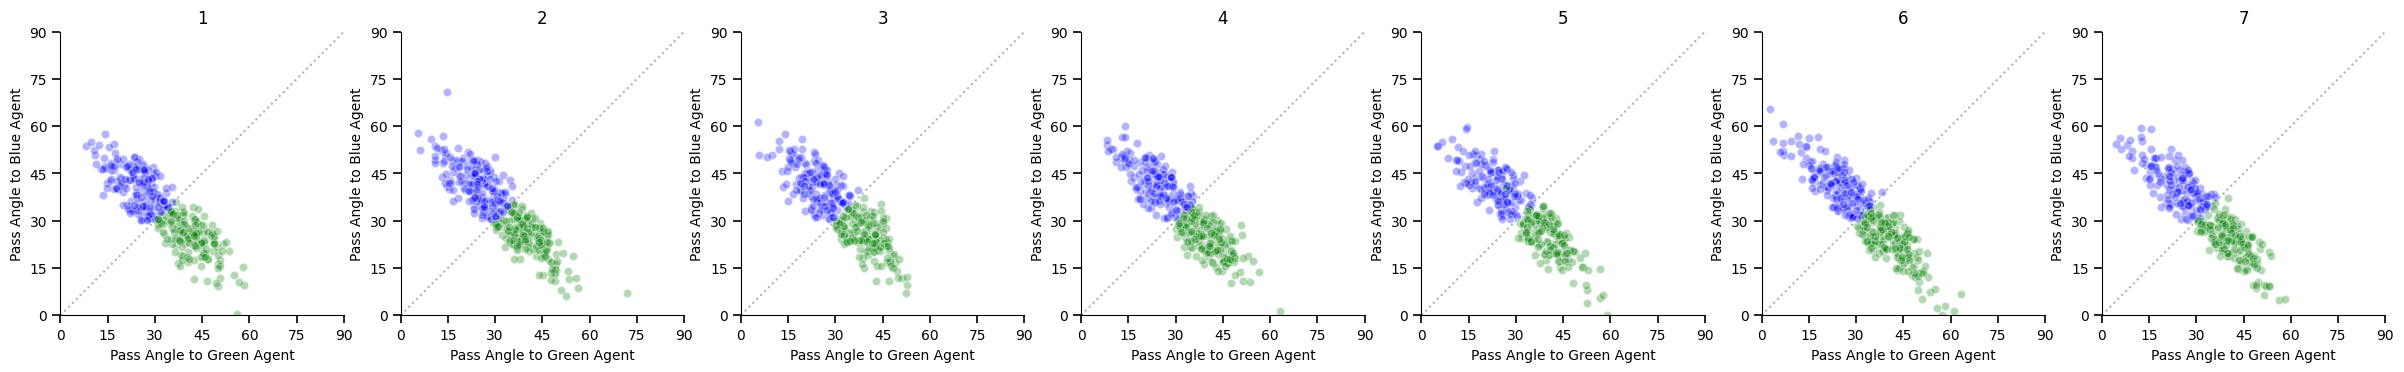

2
E


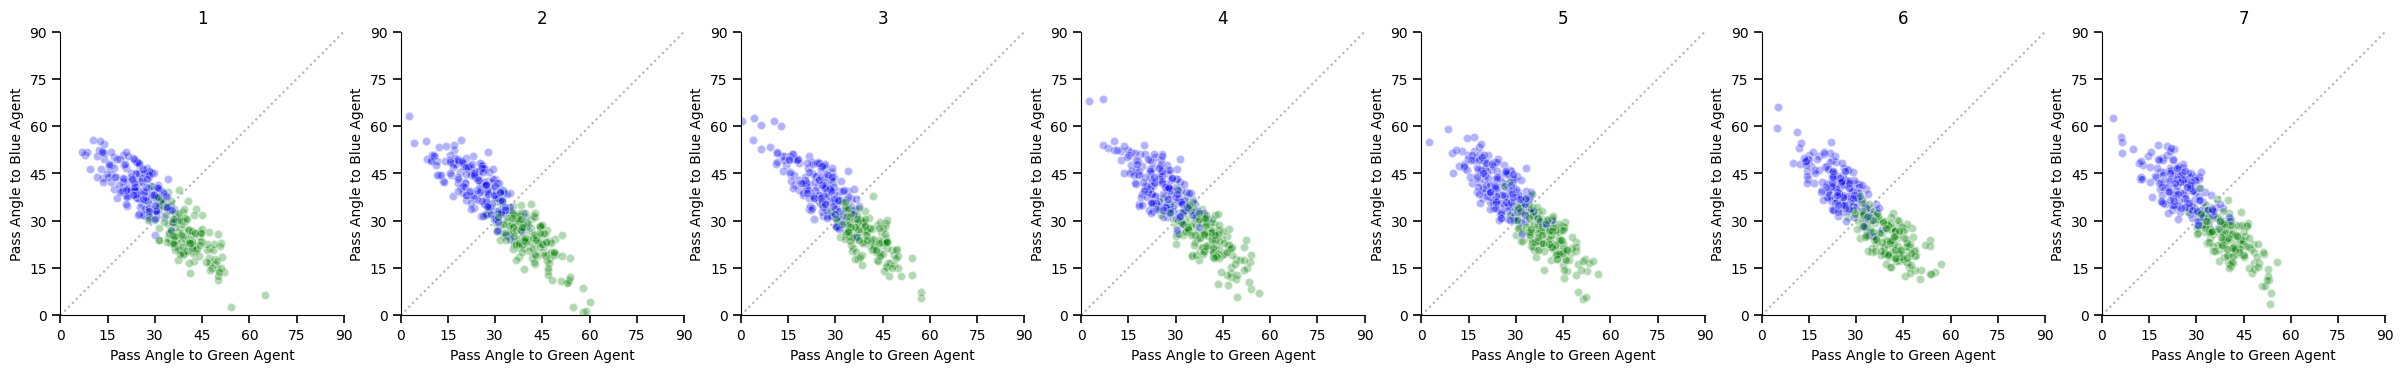

4
E


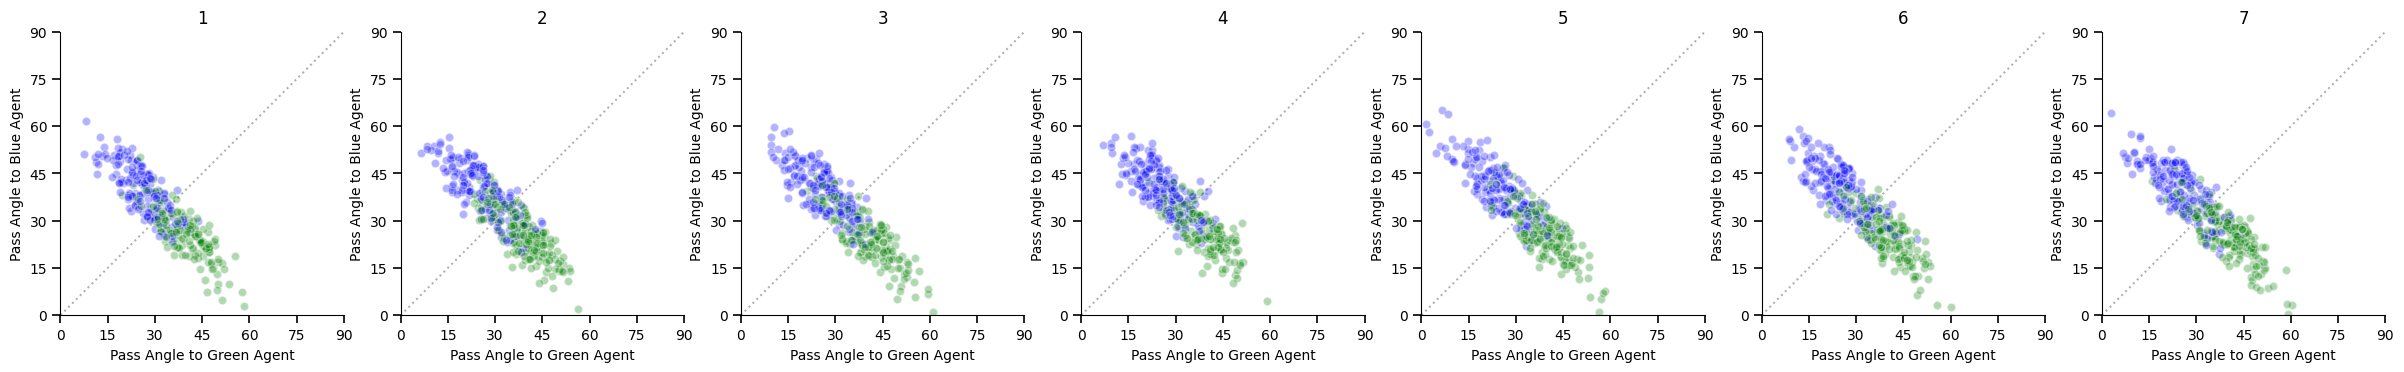

8
E


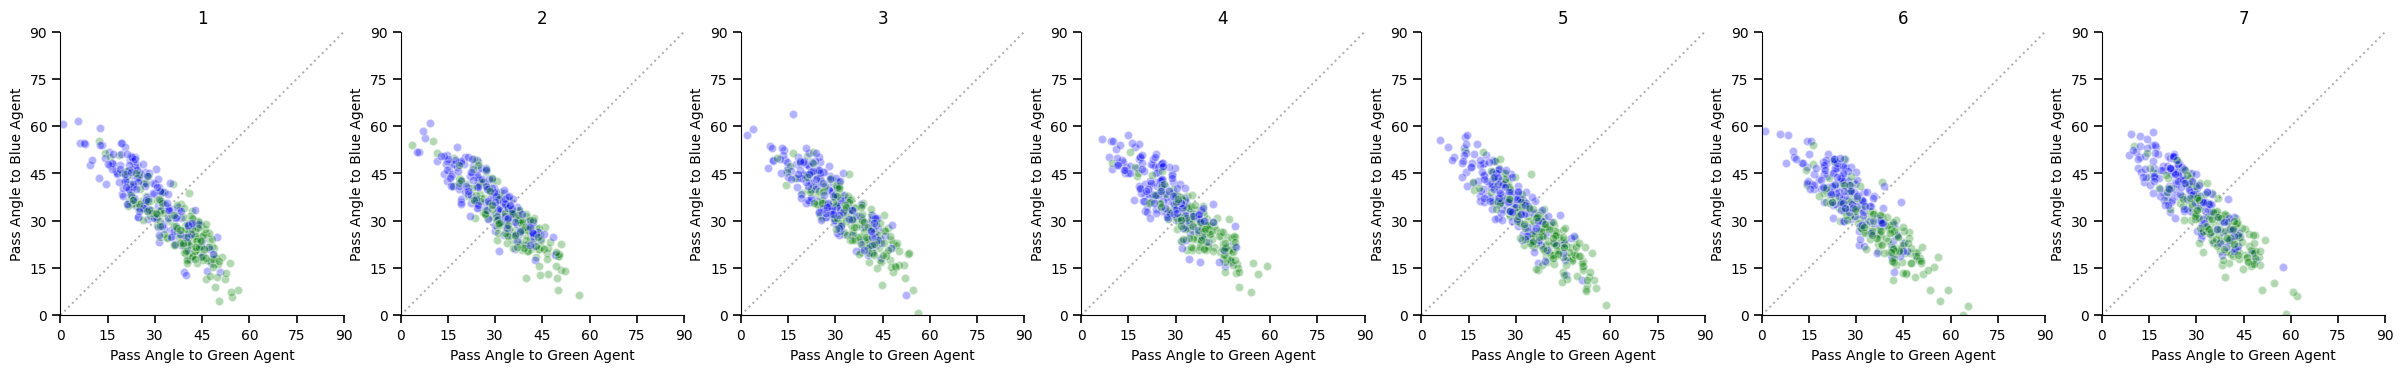

16
E


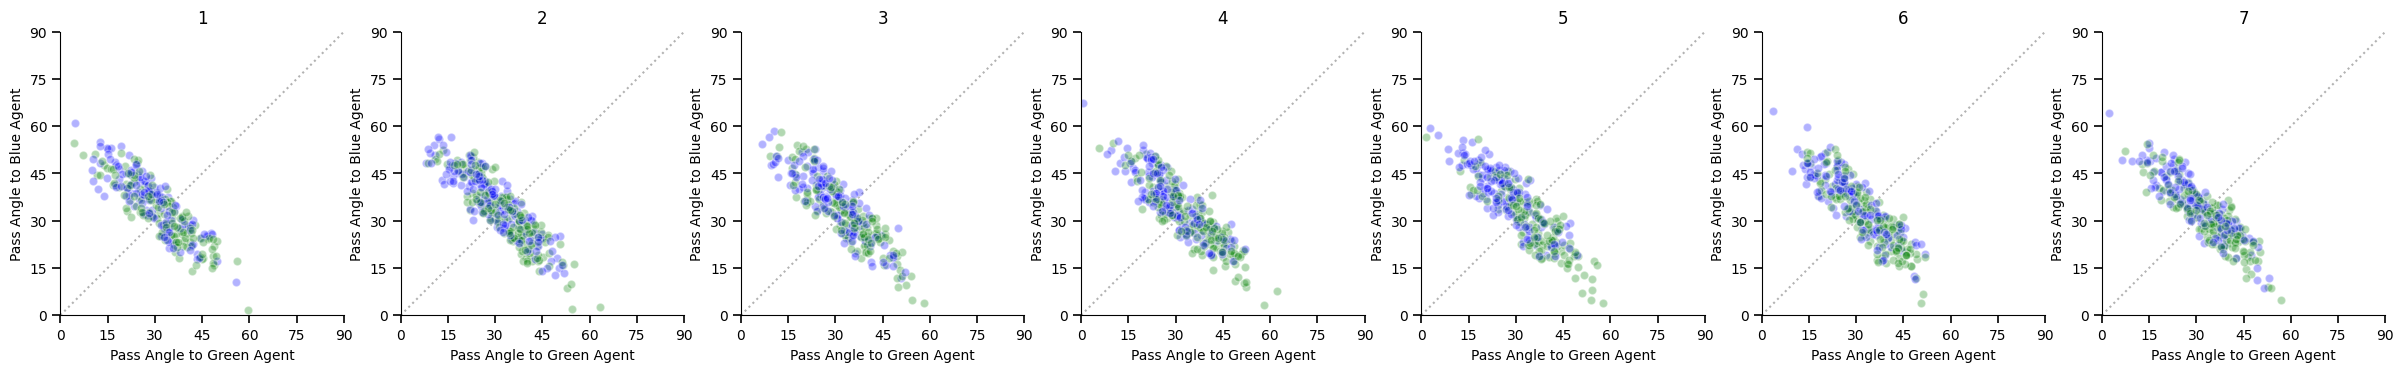

32
E


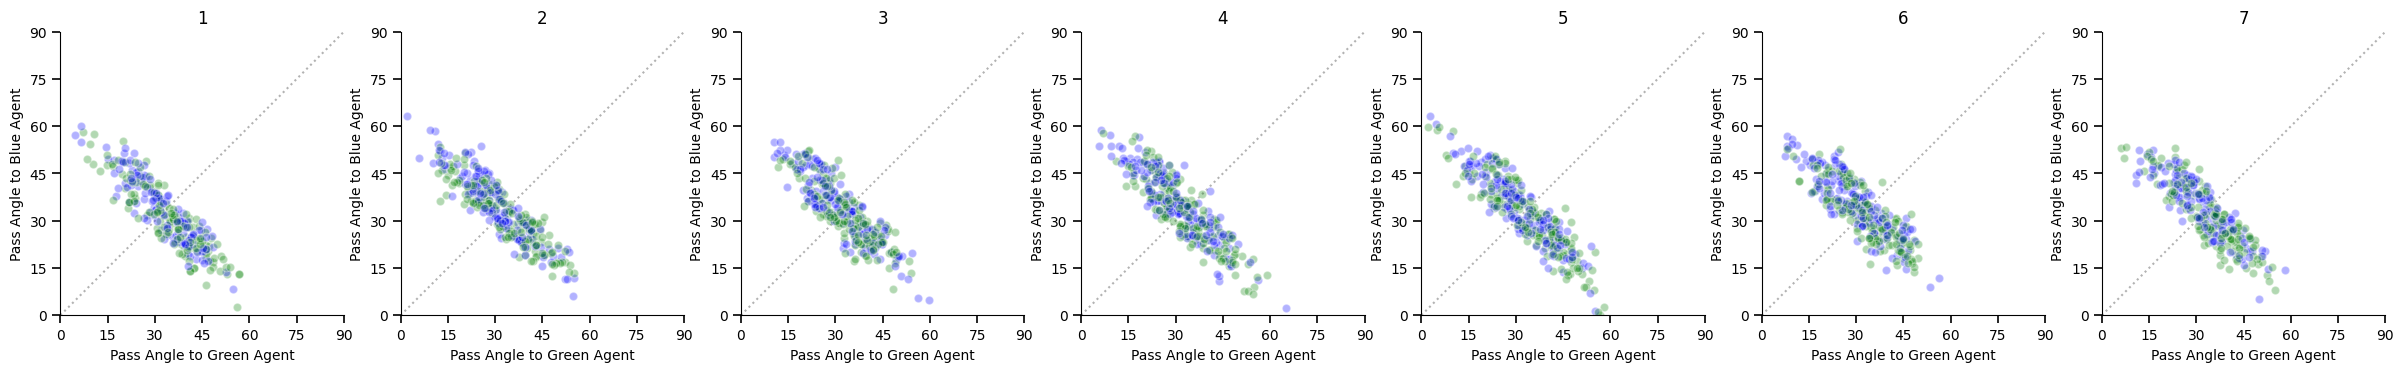

64
E


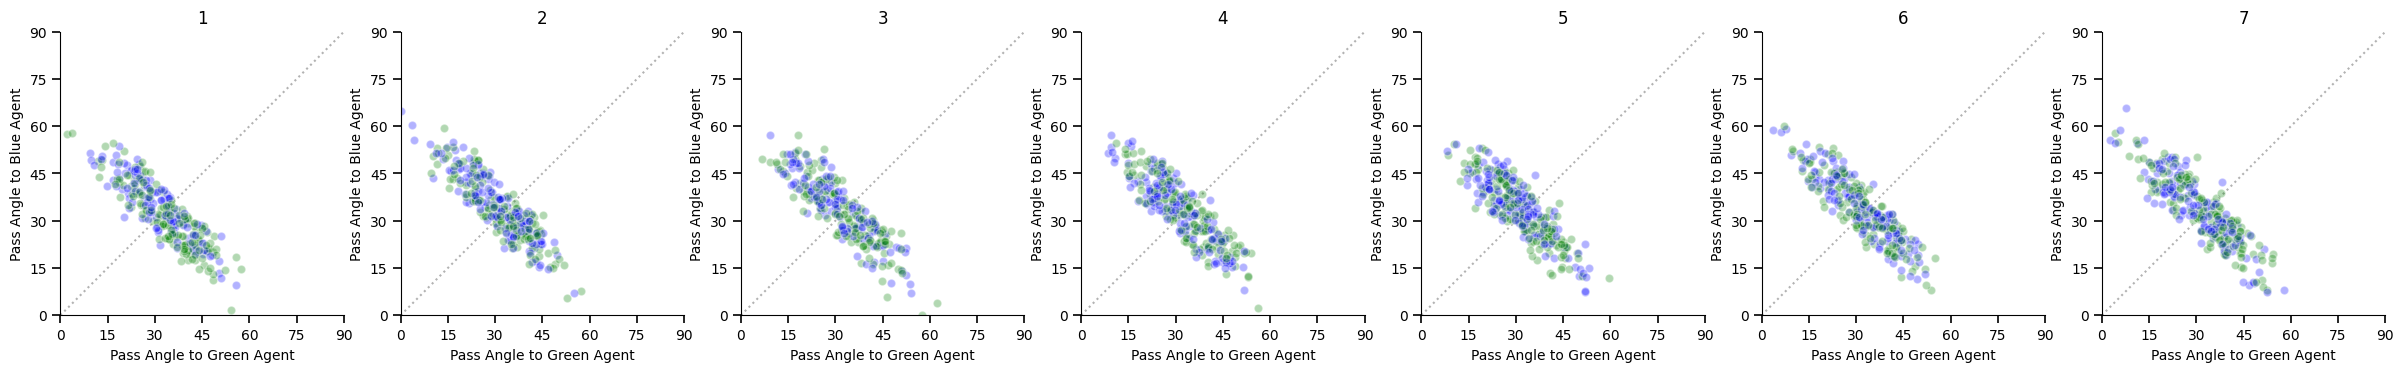

128
E


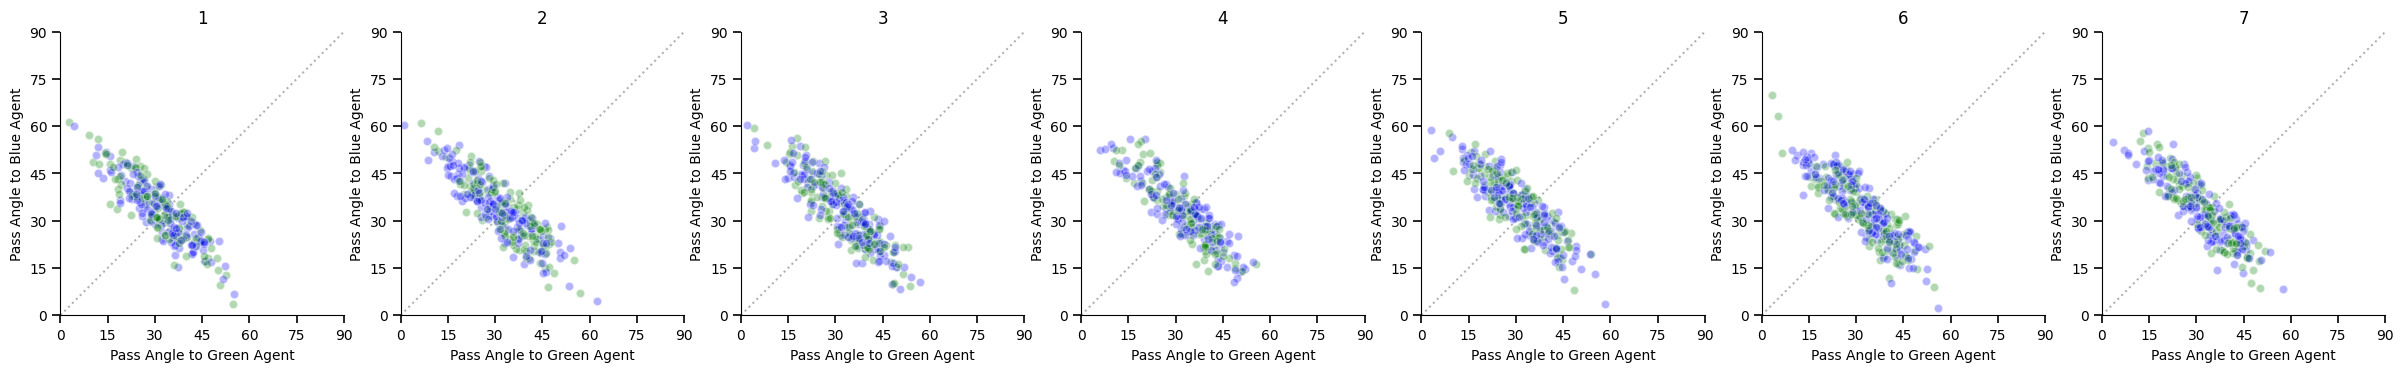

256
E


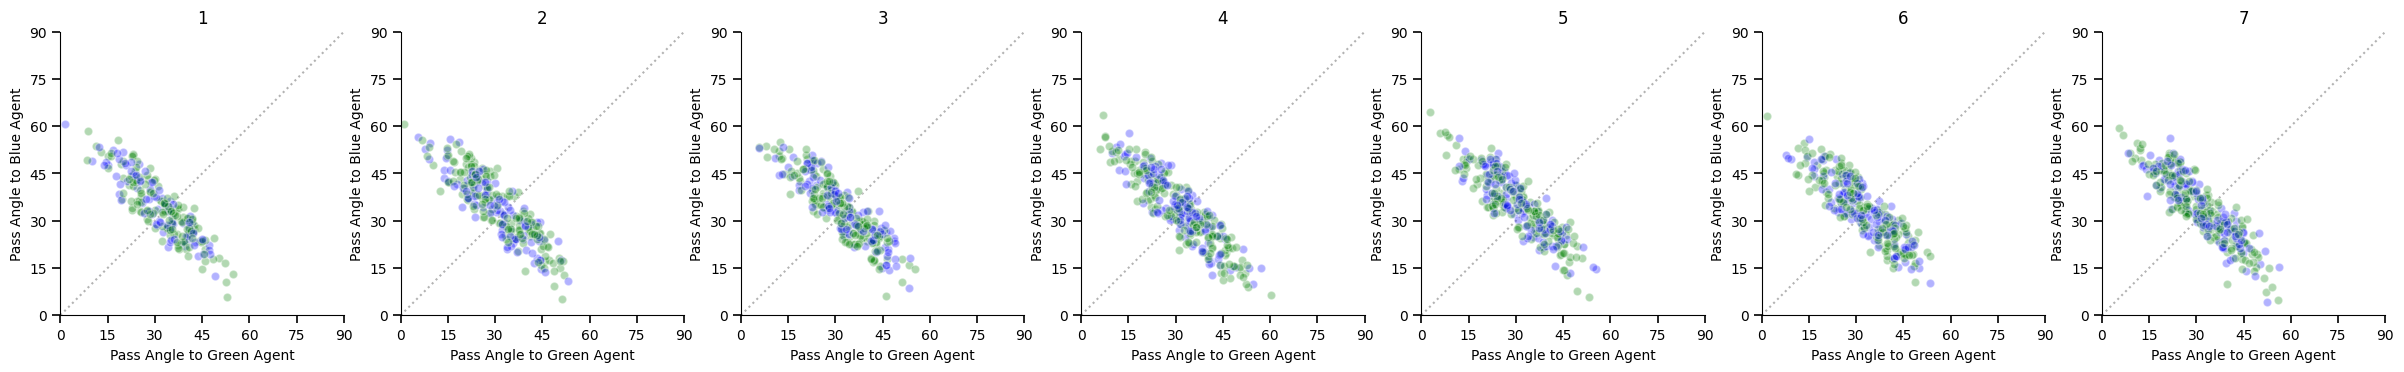

512
E


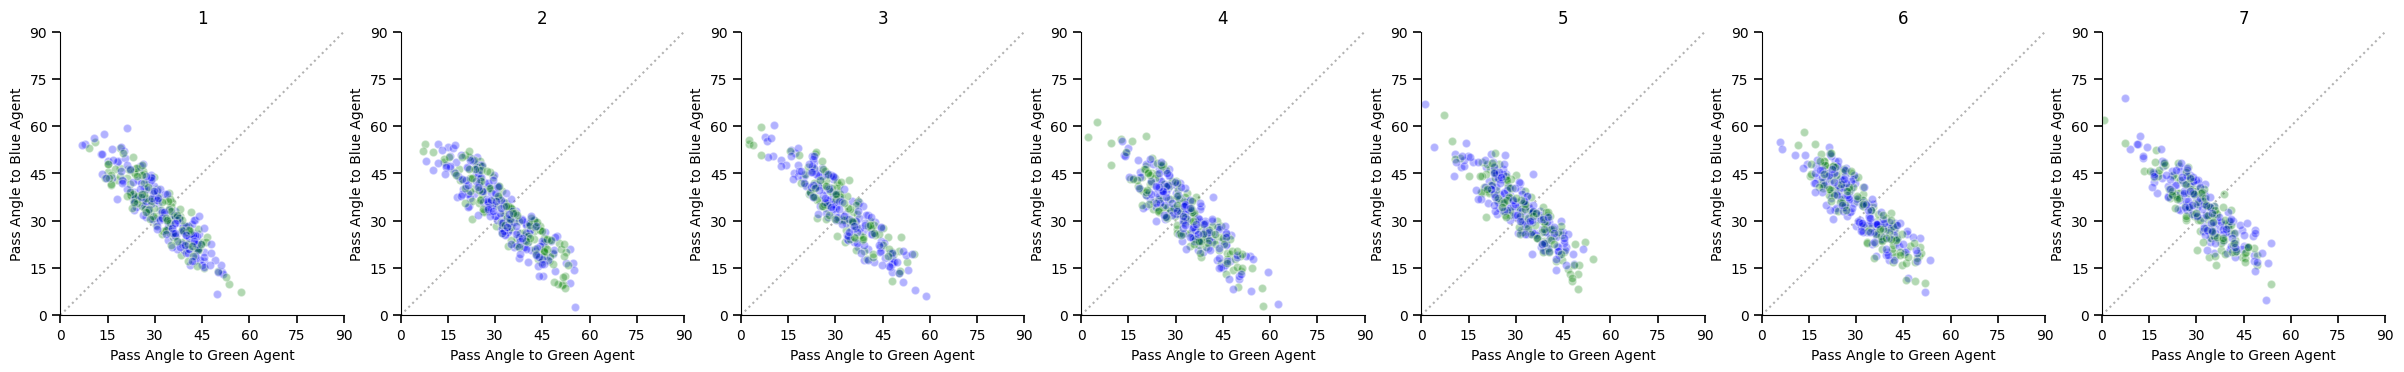

1024
E


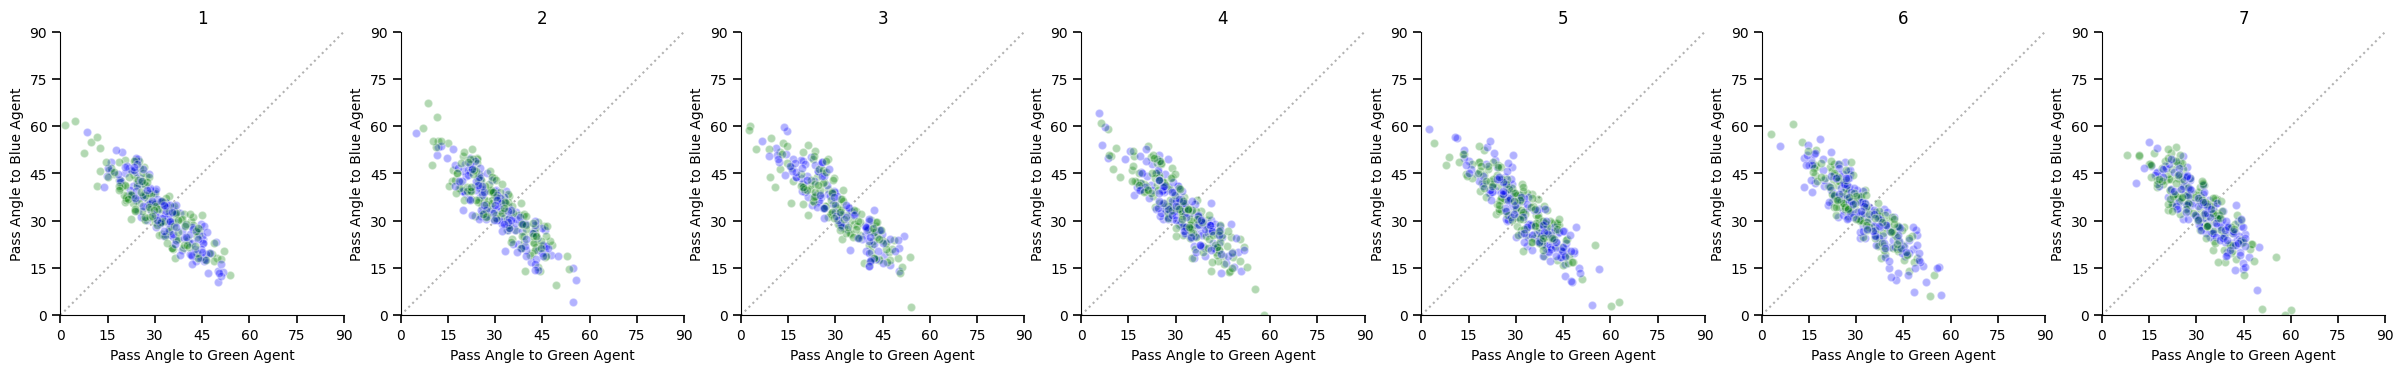

In [4]:
alphabets = list("E") 

threshold_max = 50
sigma_list = [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

for sigma in sigma_list:
    print(sigma)
    
    for alphabet_num in range(len(alphabets)):
        print(alphabets[alphabet_num])

        fig = plt.figure(figsize=(30,5))

        for sub_num in range(7):

            sub = '{0:03d}'.format(sub_num+1)

            ax = fig.add_subplot(1, 7, sub_num +1)
            ax.plot([0, 90], [0, 90], linestyle='dotted', color='gray', alpha=0.6, zorder=0)

            pass_angle_a1 = []
            pass_angle_a2 = []
            pass_angle_a3 = []
            pass_to_a1 = []
            pass_to_a2 = []
            pass_to_a3 = []

            for con_num in range(3):

                con_alphabet = alphabets[alphabet_num]       
                condition = con_alphabet + str(con_num + 1)  

                load_name = f"../data/agent/max_sigma/max_{threshold_max}/sigma_{sigma}/agent{sub}/agent{sub}_{condition}.npy"
                pos_list = np.load(load_name, allow_pickle=True)

                for episode in range(8):

                    pos_episode = pos_list[episode]
                    defender_pos_episode = pos_episode[0]
                    attacker1_pos_episode = pos_episode[1]
                    attacker2_pos_episode = pos_episode[2]
                    attacker3_pos_episode = pos_episode[3]
                    ball_pos_episode = pos_episode[4]

                    threshold = 1e-2
                    for t in range(len(defender_pos_episode) - 1):                

                        # attacker1
                        dist_now_1 = np.linalg.norm(attacker1_pos_episode[t] - ball_pos_episode[t])
                        dist_next_1 = np.linalg.norm(attacker1_pos_episode[t+1] - ball_pos_episode[t+1])

                        if dist_now_1 < threshold and dist_next_1 >= threshold:
                            pass_ang_a2, pass_ang_a3, pass_to = get_pass_angle(attacker1_pos_episode[t], attacker2_pos_episode[t], attacker3_pos_episode[t], defender_pos_episode[t], ball_pos_episode[t], ball_pos_episode[t+1])

                            pass_angle_a1.append([pass_ang_a2, pass_ang_a3])
                            pass_to_a1.append(pass_to)
                        else:
                            pass

            for i in range(len(pass_angle_a1)):

                pass_angle_i = pass_angle_a1[i]
                pass_to_i = pass_to_a1[i]

                if pass_to_i == "a2":
                    ax.scatter(pass_angle_i[0], pass_angle_i[1], color='green', edgecolor='white', alpha=0.3)
                elif pass_to_i == "a3":
                    ax.scatter(pass_angle_i[0], pass_angle_i[1], color='blue', edgecolor='white', alpha=0.3)

            ax.set_xlabel("Pass Angle to Green Agent")
            ax.set_ylabel("Pass Angle to Blue Agent")
            ax.set_xlim(0, 90)
            ax.set_ylim(0, 90)
            ax.set_xticks([0, 15, 30, 45, 60,  75, 90])
            ax.set_yticks([0, 15, 30, 45, 60,  75, 90])
            ax.set_aspect('equal', adjustable='box')
            box = ax.get_position()
            ax.tick_params(
                axis='both', direction='out', length=6, width=1.2,
                bottom=True, top=False, left=True, right=False
            )
            [ax.spines[side].set_visible(False) for side in ['right', 'top']]
            ax.set_title(f"{sub_num+1}")

        plt.show()


# Fig. 3k

In [5]:
alphabets = list("ABCDEFGHI") 

threshold_max = 50
sigma_list = [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

sigma_all_pass_rate_a1_agent = []
sigma_all_pass_rate_a2_agent = []
sigma_all_pass_rate_a3_agent = []

for sigma in sigma_list:
    print(f"=== sigma = {sigma} ===")
    

    all_pass_rate_a1_agent = []
    all_pass_rate_a2_agent = []
    all_pass_rate_a3_agent = []

    for sub_num in range(28):

        pass_rate_a1 = []
        pass_rate_a2 = []
        pass_rate_a3 = []

        for alphabet_num in range(len(alphabets)):

            pass_outcome_a1 = []
            pass_outcome_a2 = []
            pass_outcome_a3 = []

            for con_num in range(3):

                con_alphabet = alphabets[alphabet_num]       
                sub = '{0:03d}'.format(sub_num + 1)
                condition = con_alphabet + str(con_num + 1)

                load_name = f"../data/agent/max_sigma/max_{threshold_max}/sigma_{sigma}/agent{sub}/agent{sub}_{condition}.npy"
                pos_list = np.load(load_name, allow_pickle=True)

                for episode in range(8):

                    pass_episode_a1 = []
                    pass_episode_a2 = []
                    pass_episode_a3 = []

                    pos_episode = pos_list[episode]
                    defender_pos_episode = pos_episode[0]
                    attacker1_pos_episode = pos_episode[1]
                    attacker2_pos_episode = pos_episode[2]
                    attacker3_pos_episode = pos_episode[3]
                    ball_pos_episode = pos_episode[4]

                    pass_a1, pass_a2, pass_a3 = initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode)
                    pass_episode_a1.append(pass_a1)
                    pass_episode_a2.append(pass_a2)
                    pass_episode_a3.append(pass_a3)

                    if pass_a1==1:
                        pass_outcome_a1.append(pass_a1)
                    elif pass_a2:
                        pass_outcome_a2.append(pass_a2)
                    elif pass_a3:
                        pass_outcome_a3.append(pass_a3)

                    threshold = 1e-2
                    for t in range(len(defender_pos_episode) - 1):                

                        # attacker1
                        dist_now_1 = np.linalg.norm(attacker1_pos_episode[t] - ball_pos_episode[t])
                        dist_next_1 = np.linalg.norm(attacker1_pos_episode[t+1] - ball_pos_episode[t+1])
                        if dist_now_1 < threshold and dist_next_1 >= threshold:
                            pass_episode_a1.append(1)
                            pass_outcome_a1.append(1)
                        else:
                            pass_episode_a1.append(0)

                        # attacker2
                        dist_now_2 = np.linalg.norm(attacker2_pos_episode[t] - ball_pos_episode[t])
                        dist_next_2 = np.linalg.norm(attacker2_pos_episode[t+1] - ball_pos_episode[t+1])
                        if dist_now_2 < threshold and dist_next_2 >= threshold:
                            pass_episode_a2.append(1)
                            pass_outcome_a2.append(1)
                        else:
                            pass_episode_a2.append(0)

                        # attacker3
                        dist_now_3 = np.linalg.norm(attacker3_pos_episode[t] - ball_pos_episode[t])
                        dist_next_3 = np.linalg.norm(attacker3_pos_episode[t+1] - ball_pos_episode[t+1])
                        if dist_now_3 < threshold and dist_next_3 >= threshold:
                            pass_episode_a3.append(1)
                            pass_outcome_a3.append(1)
                        else:
                            pass_episode_a3.append(0)

                    last_pass = last_pass_check(defender_pos_episode, ball_pos_episode)                 
                    dist_next_b = np.linalg.norm(ball_pos_episode[-1] - np.array([0, 0]))
                    if last_pass == 0 or dist_next_b >= 0.8:

                        idx_a1 = get_last_pass_index(pass_episode_a1)
                        idx_a2 = get_last_pass_index(pass_episode_a2)
                        idx_a3 = get_last_pass_index(pass_episode_a3)

                        last_idx = max(idx_a1, idx_a2, idx_a3)

                        if last_idx == idx_a1:
                            last_passer = "a1"
                        elif last_idx == idx_a2:
                            last_passer = "a2"
                        elif last_idx == idx_a3:
                            last_passer = "a3"
                        else:
                            last_passer = "none"

                        if last_passer == "a1":
                            pass_outcome_a1[-1] = 0
                        elif last_passer == "a2":
                            pass_outcome_a2[-1] = 0
                        elif last_passer == "a3":
                            pass_outcome_a3[-1] = 0

            pass_rate_a1.append(np.mean(pass_outcome_a1))
            pass_rate_a2.append(np.mean(pass_outcome_a2))
            pass_rate_a3.append(np.mean(pass_outcome_a3))

        all_pass_rate_a1_agent.append(pass_rate_a1)
        all_pass_rate_a2_agent.append(pass_rate_a2)
        all_pass_rate_a3_agent.append(pass_rate_a3)

    sigma_all_pass_rate_a1_agent.append(all_pass_rate_a1_agent)
    sigma_all_pass_rate_a2_agent.append(all_pass_rate_a2_agent)
    sigma_all_pass_rate_a3_agent.append(all_pass_rate_a3_agent)

=== sigma = 0 ===
=== sigma = 2 ===
=== sigma = 4 ===
=== sigma = 8 ===
=== sigma = 16 ===
=== sigma = 32 ===
=== sigma = 64 ===
=== sigma = 128 ===
=== sigma = 256 ===
=== sigma = 512 ===
=== sigma = 1024 ===


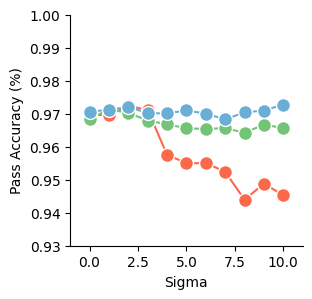

In [11]:
   
mean_pass_rate_a1_agent = np.array(sigma_all_pass_rate_a1_agent).mean(axis=2).mean(axis=1)
mean_pass_rate_a2_agent = np.array(sigma_all_pass_rate_a2_agent).mean(axis=2).mean(axis=1)
mean_pass_rate_a3_agent = np.array(sigma_all_pass_rate_a3_agent).mean(axis=2).mean(axis=1)

color_r = matplotlib.colormaps["Reds"](0.5)
color_g = matplotlib.colormaps["Greens"](0.5)
color_b = matplotlib.colormaps["Blues"](0.5)

point_size = 100
xs = range(11)
fig, ax = plt.subplots(figsize=(3, 3))

plt.plot(mean_pass_rate_a1_agent, color=color_r, zorder=0, alpha=1)
plt.plot(mean_pass_rate_a2_agent, color=color_g, zorder=0, alpha=1)
plt.plot(mean_pass_rate_a3_agent, color=color_b, zorder=0, alpha=1)

ax.scatter(xs, mean_pass_rate_a1_agent, color=color_r, edgecolor='white', s=point_size, zorder=1, alpha=1)
ax.scatter(xs, mean_pass_rate_a2_agent, color=color_g, edgecolor='white', s=point_size, zorder=1, alpha=1)
ax.scatter(xs, mean_pass_rate_a3_agent, color=color_b, edgecolor='white', s=point_size, zorder=1, alpha=1)

ax.set_xlabel("Sigma")
ax.set_ylabel("Pass Accuracy (%)")
ax.set_xlim(-1, 11)
ax.set_ylim(0.93, 1)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
[ax.spines[side].set_visible(False) for side in ['right', 'top']]

plt.show()


In [14]:
# -*- coding: utf-8 -*-
# Mixed-effects model for logit(pass success rate) across σ values
# Random effects: (1 + sigma_c + ball_c + def_c | subject)

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# ---------------------------
# Inputs
sigma_list = [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
data = np.array(sigma_all_pass_rate_a2_agent).reshape(11, 3, 3, 28)

# Logit transform with clipping to avoid boundaries
def logit_clip(x, eps=1e-4):
    x = np.clip(x, eps, 1 - eps)
    return np.log(x / (1 - x))

data_logit = logit_clip(data)

# Build long-format dataframe
rows = []
for th_idx, sigma in enumerate(sigma_list):
    for b in range(3):
        for d in range(3):
            for s in range(28):
                rows.append({
                    "subject": f"S{s:03d}",
                    "sigma": float(sigma),
                    "ball_lv": b,
                    "def_lv": d,
                    "pass_rate_logit": float(data_logit[th_idx, b, d, s]),
                })
df_long = pd.DataFrame(rows)

# Factors for ball/def
df_long["ball_lv"] = pd.Categorical(df_long["ball_lv"], categories=[0, 1, 2])
df_long["def_lv"]  = pd.Categorical(df_long["def_lv"],  categories=[0, 1, 2])

# Numeric copies for random-slope terms
df_long["ball_c"] = df_long["ball_lv"].astype(int)
df_long["def_c"]  = df_long["def_lv"].astype(int)

# Log-transform σ (add +1 to allow σ=0) and mean-center
df_long["sigma_log"] = np.log2(df_long["sigma"] + 1)
df_long["sigma_c"]   = df_long["sigma_log"] - df_long["sigma_log"].mean()

# ---- MixedLM with random slopes
fit = smf.mixedlm(
    "pass_rate_logit ~ sigma_c * C(ball_lv) * C(def_lv)",
    data=df_long,
    groups=df_long["subject"],
    re_formula="~ sigma_c + ball_c + def_c"
).fit(method="lbfgs", maxiter=1000)

print("\n=== MixedLM (logit pass rate) with random slopes: sigma, ball, def ===")
print(fit.summary())


/Users/tsutsuikazushi/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tsutsuikazushi/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/tsutsuikazushi/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 187.296315
  warnings.warn(msg, ConvergenceWarning)



=== MixedLM (logit pass rate) with random slopes: sigma, ball, def ===
                      Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       pass_rate_logit
No. Observations:         2772          Method:                   REML           
No. Groups:               28            Scale:                    4.7832         
Min. group size:          99            Log-Likelihood:           -6247.9455     
Max. group size:          99            Converged:                No             
Mean group size:          99.0                                                   
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               5.199    0.208 24.986 0.000  4.791  5.607
C(ball_lv)[T.1]                         0.118   

/Users/tsutsuikazushi/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
